In [25]:
import cartopy.io.img_tiles as cimgt
import glob
from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt

In [11]:
import sailboat as sb # local file sailboat.py
## this is to be able to edit the sailboat.py file and no need to refress
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# sat image tile
request = cimgt.GoogleTiles(style='satellite')

In [21]:
files = glob.glob('./Data/*.csv')
local = sb.get_data(files)
local['phyco/chla'] = local['Phycocyanin [ppb]']/local['Chl. a [ppb]']
local.set_index('local time', inplace=True)
local

,GPSTimeStamp,Lon,Lat,O2 Concentration [micromolar],O2 Saturation [%],Bb(470) [NTU],Bb(532) [NTU],Bb(650) [NTU],CDOM [QSU],Chl. a [ppb],Phycocyanin [ppb],phyco/chla
local time,,,,,,,,,,,,
2020-12-30 18:59:28-05:00,2020-12-30 23:59:28,-80.802025,27.217388,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,0.539515
2020-12-30 18:59:19-05:00,2020-12-30 23:59:19,-80.802025,27.217390,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,0.539515
2020-12-30 18:59:06-05:00,2020-12-30 23:59:06,-80.802017,27.217392,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,0.539515
2020-12-30 18:58:54-05:00,2020-12-30 23:58:54,-80.802017,27.217396,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,0.539515
2020-12-30 18:58:48-05:00,2020-12-30 23:58:48,-80.802017,27.217398,252.22,96.15,0.000,0.000,0.000,607.66,2189.17,1181.09,0.539515
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 20:01:26-04:00,2021-03-31 00:01:26,-80.743240,26.981470,240.30,94.44,27.853,26.465,33.236,157.28,21.65,5.23,0.241570
2021-03-30 20:01:06-04:00,2021-03-31 00:01:06,-80.743393,26.981449,240.30,94.44,27.853,26.465,33.236,157.28,21.65,5.23,0.241570
2021-03-30 20:00:45-04:00,2021-03-31 00:00:45,-80.743507,26.981367,240.29,94.41,28.095,26.708,33.721,156.05,20.92,5.79,0.276769


In [53]:
local.dtypes

GPSTimeStamp                     datetime64[ns]
Lon                                     float64
Lat                                     float64
O2 Concentration [micromolar]           float64
O2 Saturation [%]                       float64
Bb(470) [NTU]                           float64
Bb(532) [NTU]                           float64
Bb(650) [NTU]                           float64
CDOM [QSU]                              float64
Chl. a [ppb]                            float64
Phycocyanin [ppb]                       float64
phyco/chla                              float64
dtype: object

In [22]:
day = local.between_time('6:00', '18:00', include_end=False)
night = local.between_time('18:00', '6:00', include_end=False)

Text(0.5, 1.0, 'Night time')

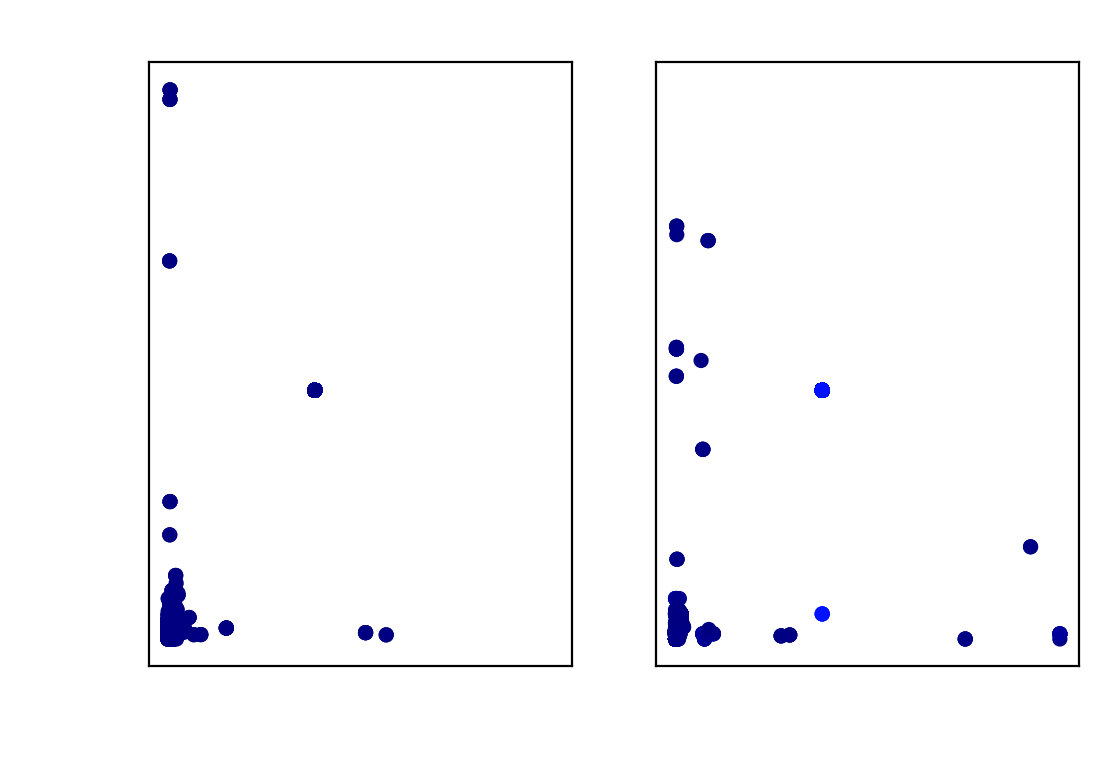

In [52]:
fig, axes = plt.subplots(1,2, sharey=True, sharex=True, dpi=200)
sb.scatter(day, 'phyco', 'chla', ax=axes[0], colorbar=False)
axes[0].set_title('Day time')
sb.scatter(night, 'phyco', 'chla', ax=axes[1], colorbar=False)
axes[1].set_title('Night time')

(0.0, 500.0)

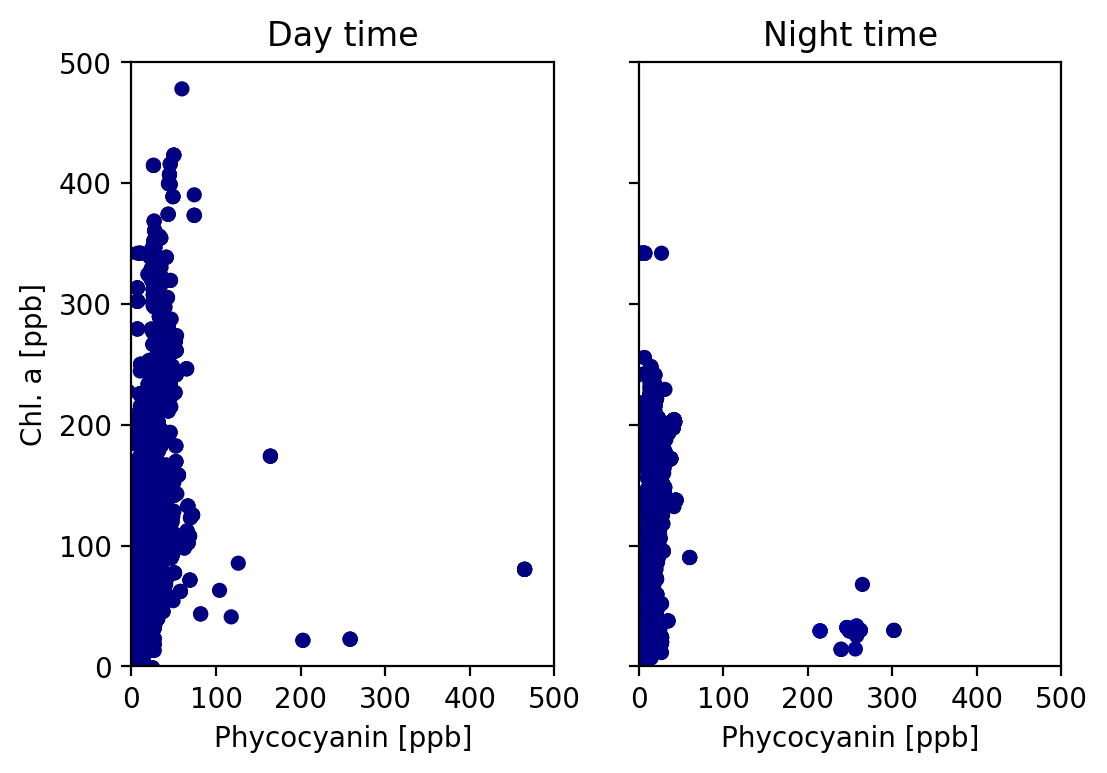

In [33]:
fig, axes = plt.subplots(1,2, sharey=True, sharex=True, dpi=200)
sb.scatter(day, 'phyco', 'chla', ax=axes[0], colorbar=False)
axes[0].set_title('Day time')
sb.scatter(night, 'phyco', 'chla', ax=axes[1], colorbar=False)
axes[1].set_title('Night time')
axes[0].set_xlim(0,500)
axes[0].set_ylim(0,500)

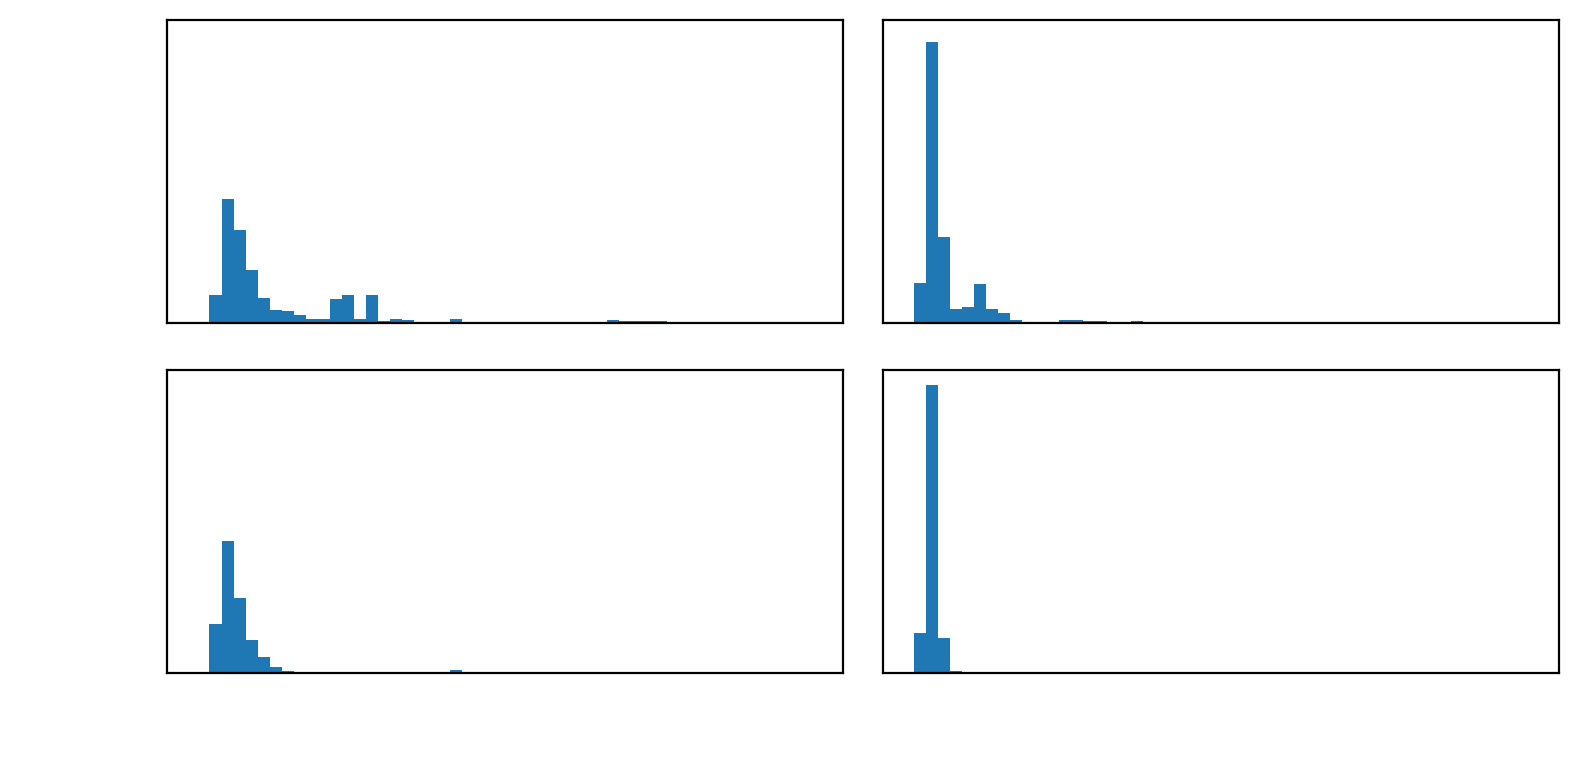

In [51]:
fore_color='white'
plt.rcParams["text.color"] = fore_color
plt.rcParams["axes.labelcolor"] = fore_color
plt.rcParams["xtick.color"] =  fore_color
plt.rcParams["ytick.color"] = fore_color

fig, axes = plt.subplots(2,2, sharey=True, sharex='col', dpi=200, figsize=(8,4))
cbins = np.arange(-10, 510, 10)
day['Chl. a [ppb]'].plot.hist(bins=cbins, ax=axes[0,0])
night['Chl. a [ppb]'].plot.hist(bins=cbins, ax=axes[1,0])
axes[1, 0].set_xlabel('Chl. a [ppb]')

day['Phycocyanin [ppb]'].plot.hist(bins=cbins, ax=axes[0,1])
night['Phycocyanin [ppb]'].plot.hist(bins=cbins, ax=axes[1,1])
axes[1,1].set_xlabel('Phycocyanin [ppb]')
fig.tight_layout()

In [38]:
import numpy as np

In [40]:
np.arange(-10, 510, 10)

array([-10,   0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110,
       120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240,
       250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370,
       380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500])